# Comparison of Neural Network Designs in Classifying Points into Multiple Non-Linearly-Separable Regions

In this notebook, we generate a random (uniformly distributed) scattered set of points, and we overlay a Venn Diagram (two circles of $r=1$, centered at $(0, 0)$ and $(1, 0)$), based on which we classify the points into one of four categories -- A only, B only, A and B, and Outside. 
Our objective is to train a neural network to classify the points into each of those categories. We experiment with three different NN designs, presented below. 

## Prerequisites

We generate the data and the labels

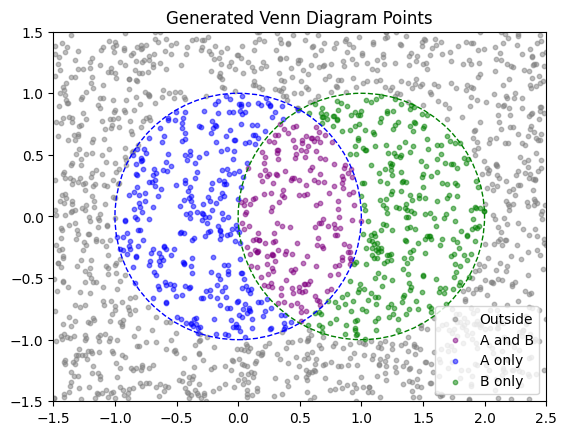

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_label(x, y, r=1.0, d=1.0):
    in_A = (x**2 + y**2) <= r**2
    in_B = ((x - d)**2 + y**2) <= r**2

    if in_A and in_B:
        label = 'A and B'
    elif in_A:
        label = 'A only'
    elif in_B:
        label = 'B only'
    else:
        label = 'Outside' 

    return label 

def generate_venn_points_df(n_points=1000):
    """
    Generate a DataFrame with (x, y) points and labels for a two-set Venn diagram.

    Parameters:
    - n_points: number of total points to generate

    Returns:
    - DataFrame with columns ['x', 'y', 'label'] where label is one of:
        'A only', 'B only', 'A and B', 'Outside'
    """
    r=1.0
    d=1.0
    points = []
    count = 0

    while count < n_points:
        x = np.random.uniform(-1.5, 2.5)
        y = np.random.uniform(-1.5, 1.5)

        points.append((x, y, generate_label(x, y, r, d)))
        count += 1

    df = pd.DataFrame(points, columns=["x", "y", "label"])
    return df

# Visualization function
def plot_venn_df(df):
    colors = {
        'A only': 'blue',
        'B only': 'green',
        'A and B': 'purple',
        'Outside': 'gray'
    }
    for label in df['label'].unique():
        subset = df[df['label'] == label]
        plt.scatter(subset['x'], subset['y'], s=10, alpha=0.5, label=label, color=colors[label])
    
    # Add circle outlines
    circle_A = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
    circle_B = plt.Circle((1, 0), 1, color='green', fill=False, linestyle='--')
    plt.gca().add_patch(circle_A)
    plt.gca().add_patch(circle_B)

    plt.gca().set_aspect('equal')
    plt.xlim(-1.5, 2.5)
    plt.ylim(-1.5, 1.5)
    plt.legend(loc='lower right')
    plt.title("Generated Venn Diagram Points")
    plt.show()

# Generate and display our training dataframe
df = generate_venn_points_df(n_points=2000)
plot_venn_df(df)


We set up our Dataset and DataLoader structures below

In [63]:
import torch 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset

class PointsDataset(Dataset):
    def __init__(self, df, label_map=None):
        """
        Args:
            df: Pandas DataFrame with columns 'x', 'y', and 'label'
            label_map: Optional dict to map labels to integers; if None, default will be used
        """
        self.X = torch.tensor(df[['x', 'y']].values, dtype=torch.float32)
        
        if label_map is None:
            label_map = {
                'Outside': 0,
                'A only': 1,
                'B only': 2,
                'A and B': 3
            }
        
        self.y = torch.tensor(df['label'].map(label_map).values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = PointsDataset(df)
# Split into train/test indices
train_idx, test_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    random_state=42,
    stratify=dataset.y.numpy()
)

# Create subsets
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

for X, y in train_loader:
    print(X.shape)  # e.g., torch.Size([32, 1, 3, 3])
    print(y.shape)  # e.g., torch.Size([32])
    break

torch.Size([32, 2])
torch.Size([32])


Adding a visualization function of the frontiers:

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_decision_surface(model, dataset, title="Decision Surface", resolution=1000, venn=True):
    model.eval()

    # Get bounds
    X = dataset.X.numpy()
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2

    # Grid
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict
    with torch.no_grad():
        preds = torch.argmax(model(grid_tensor), dim=1).numpy()

    zz = preds.reshape(xx.shape)

    # Define custom colormap and normalization for 4 discrete classes
    label_colors = ['gray', 'blue', 'green', 'purple']
    label_names = ['Outside', 'A only', 'B only', 'A and B']
    cmap = mcolors.ListedColormap(label_colors)
    bounds = np.arange(-0.5, 4.5, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot surface
    plt.contourf(xx, yy, zz, levels=bounds, cmap=cmap, norm=norm, alpha=0.3)
    cbar = plt.colorbar(ticks=[0, 1, 2, 3])
    cbar.set_label('Class')
    cbar.set_ticklabels(label_names)

    # Scatter actual data
    for class_idx in range(4):
        mask = dataset.y.numpy() == class_idx
        plt.scatter(X[mask, 0], X[mask, 1], s=10, label=label_names[class_idx], 
                    color=label_colors[class_idx], edgecolor='k', alpha=0.6)

    # Overlay Venn circles
    if venn:
        circle_A = plt.Circle((0, 0), 1, color='black', fill=False, linestyle=':', linewidth=1.5)
        circle_B = plt.Circle((1, 0), 1, color='black', fill=False, linestyle=':', linewidth=1.5)
        plt.gca().add_patch(circle_A)
        plt.gca().add_patch(circle_B)

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.legend(loc='lower right')
    plt.show()

Defining a training function:

In [79]:
import torch
import torch.nn as nn
from torch.optim import Adam

def train_model(model, train_loader, test_loader, n_epochs=20, lr=0.001, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_X.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

        avg_loss = total_loss / total
        accuracy = correct / total
        print(f"Epoch {epoch+1:02d}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

    test_accuracy = correct / total
    print()
    print(f"Test Accuracy after epoch {n_epochs}: {test_accuracy:.4f}")

    return model, test_accuracy


## Network 1: Simple Net (Linear Model)

In [65]:
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 4)

    def forward(self, x):
        return self.fc(x)

Epoch 01: Loss = 1.2376, Accuracy = 0.3588
Epoch 02: Loss = 1.2025, Accuracy = 0.4719
Epoch 03: Loss = 1.1747, Accuracy = 0.5319
Epoch 04: Loss = 1.1526, Accuracy = 0.5606
Epoch 05: Loss = 1.1350, Accuracy = 0.5725
Epoch 06: Loss = 1.1211, Accuracy = 0.5800
Epoch 07: Loss = 1.1097, Accuracy = 0.5813
Epoch 08: Loss = 1.1005, Accuracy = 0.5813
Epoch 09: Loss = 1.0930, Accuracy = 0.5813
Epoch 10: Loss = 1.0869, Accuracy = 0.5813
Epoch 11: Loss = 1.0818, Accuracy = 0.5813
Epoch 12: Loss = 1.0774, Accuracy = 0.5813
Epoch 13: Loss = 1.0738, Accuracy = 0.5813
Epoch 14: Loss = 1.0709, Accuracy = 0.5813
Epoch 15: Loss = 1.0683, Accuracy = 0.5813
Epoch 16: Loss = 1.0662, Accuracy = 0.5813
Epoch 17: Loss = 1.0644, Accuracy = 0.5813
Epoch 18: Loss = 1.0629, Accuracy = 0.5813
Epoch 19: Loss = 1.0617, Accuracy = 0.5813
Epoch 20: Loss = 1.0604, Accuracy = 0.5813

Test Accuracy after epoch 20: 0.5800
Proportion of 'Outside' points: 0.5810



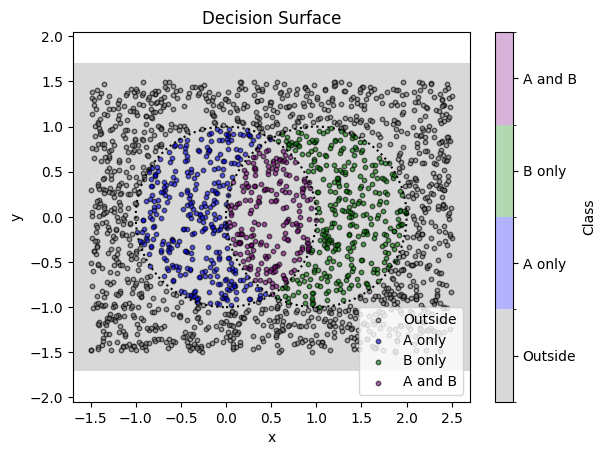

In [ ]:
simple_model = SimpleNet() 
trained_model, test_acc = train_model(simple_model, train_loader, test_loader, n_epochs=20, lr=0.001)

proportion_outside = (df['label'] == 'Outside').mean()
print(f"Proportion of 'Outside' points: {proportion_outside:.4f}\n")

plot_decision_surface(simple_model, dataset, venn=True)

Observe that we reach an accuracy of about 58%. Since this is a linear model, the model finds it easier (with highest reward) to just classify all points as being on the "Outside."

## Network 2: Shallow Net

Now, we will design a shallow network -- one which has only one hidden layer. 

In [96]:
import torch.nn as nn

class ShallowNet(nn.Module):
    def __init__(self, neuron_number = 8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, neuron_number),
            nn.ReLU(),
            nn.Linear(neuron_number, 4)
        )

    def forward(self, x):
        return self.net(x)

Epoch 01: Loss = 1.0569, Accuracy = 0.5469
Epoch 02: Loss = 0.8337, Accuracy = 0.5813
Epoch 03: Loss = 0.7158, Accuracy = 0.5919
Epoch 04: Loss = 0.6070, Accuracy = 0.7006
Epoch 05: Loss = 0.4993, Accuracy = 0.8137
Epoch 06: Loss = 0.4131, Accuracy = 0.8725
Epoch 07: Loss = 0.3439, Accuracy = 0.9000
Epoch 08: Loss = 0.2986, Accuracy = 0.9169
Epoch 09: Loss = 0.2659, Accuracy = 0.9269
Epoch 10: Loss = 0.2444, Accuracy = 0.9300
Epoch 11: Loss = 0.2217, Accuracy = 0.9456
Epoch 12: Loss = 0.2065, Accuracy = 0.9444
Epoch 13: Loss = 0.1955, Accuracy = 0.9506
Epoch 14: Loss = 0.1841, Accuracy = 0.9525
Epoch 15: Loss = 0.1754, Accuracy = 0.9525
Epoch 16: Loss = 0.1670, Accuracy = 0.9550
Epoch 17: Loss = 0.1609, Accuracy = 0.9575
Epoch 18: Loss = 0.1512, Accuracy = 0.9637
Epoch 19: Loss = 0.1489, Accuracy = 0.9681
Epoch 20: Loss = 0.1432, Accuracy = 0.9587

Test Accuracy after epoch 20: 0.9500


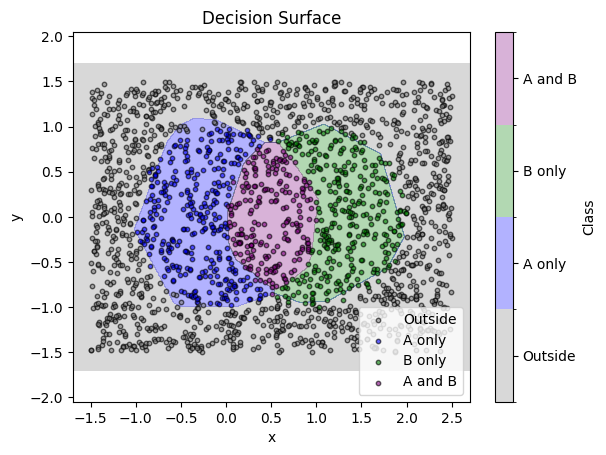

Epoch 01: Loss = 0.8789, Accuracy = 0.5663
Epoch 02: Loss = 0.5625, Accuracy = 0.7469
Epoch 03: Loss = 0.3918, Accuracy = 0.8750
Epoch 04: Loss = 0.2976, Accuracy = 0.9087
Epoch 05: Loss = 0.2436, Accuracy = 0.9256
Epoch 06: Loss = 0.2085, Accuracy = 0.9519
Epoch 07: Loss = 0.1864, Accuracy = 0.9556
Epoch 08: Loss = 0.1675, Accuracy = 0.9556
Epoch 09: Loss = 0.1554, Accuracy = 0.9663
Epoch 10: Loss = 0.1455, Accuracy = 0.9637
Epoch 11: Loss = 0.1332, Accuracy = 0.9700
Epoch 12: Loss = 0.1229, Accuracy = 0.9756
Epoch 13: Loss = 0.1212, Accuracy = 0.9675
Epoch 14: Loss = 0.1152, Accuracy = 0.9731
Epoch 15: Loss = 0.1070, Accuracy = 0.9750
Epoch 16: Loss = 0.1043, Accuracy = 0.9794
Epoch 17: Loss = 0.1129, Accuracy = 0.9681
Epoch 18: Loss = 0.1004, Accuracy = 0.9725
Epoch 19: Loss = 0.0932, Accuracy = 0.9800
Epoch 20: Loss = 0.0923, Accuracy = 0.9781

Test Accuracy after epoch 20: 0.9750


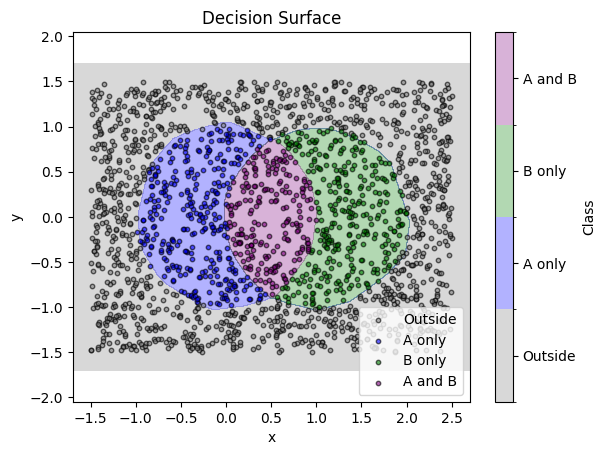

In [ ]:
shallow_model8 = ShallowNet(8) 
trained_model, test_acc = train_model(shallow_model8, train_loader, test_loader, n_epochs=20, lr=0.01)
plot_decision_surface(shallow_model8, dataset, venn=False)

shallow_model32 = ShallowNet(32) 
trained_model, test_acc = train_model(shallow_model32, train_loader, test_loader, n_epochs=20, lr=0.01)
plot_decision_surface(shallow_model32, dataset, venn=False)

We actually see that even with 1 hidden layer with 8 neurons, the network is performing quite well, though it is fairly rough on the edges. With 32 neurons in the hidden layer though, we see that the frontier line is now much smoother, and we achieve a very high accuracy of 97.50%. 

## Case 3: Full Net

In [101]:
import torch.nn as nn

class FullNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )

    def forward(self, x):
        return self.net(x)

Epoch 01: Loss = 1.3879, Accuracy = 0.1925
Epoch 02: Loss = 1.0440, Accuracy = 0.5813
Epoch 03: Loss = 0.8469, Accuracy = 0.5894
Epoch 04: Loss = 0.6692, Accuracy = 0.6687
Epoch 05: Loss = 0.5173, Accuracy = 0.7350
Epoch 06: Loss = 0.3677, Accuracy = 0.8400
Epoch 07: Loss = 0.2426, Accuracy = 0.9250
Epoch 08: Loss = 0.1617, Accuracy = 0.9700
Epoch 09: Loss = 0.1285, Accuracy = 0.9669
Epoch 10: Loss = 0.1061, Accuracy = 0.9712
Epoch 11: Loss = 0.0993, Accuracy = 0.9731
Epoch 12: Loss = 0.0839, Accuracy = 0.9788
Epoch 13: Loss = 0.0760, Accuracy = 0.9825
Epoch 14: Loss = 0.0719, Accuracy = 0.9794
Epoch 15: Loss = 0.0651, Accuracy = 0.9831
Epoch 16: Loss = 0.0705, Accuracy = 0.9769
Epoch 17: Loss = 0.0575, Accuracy = 0.9906
Epoch 18: Loss = 0.0535, Accuracy = 0.9894
Epoch 19: Loss = 0.0533, Accuracy = 0.9856
Epoch 20: Loss = 0.0501, Accuracy = 0.9894

Test Accuracy after epoch 20: 0.9800


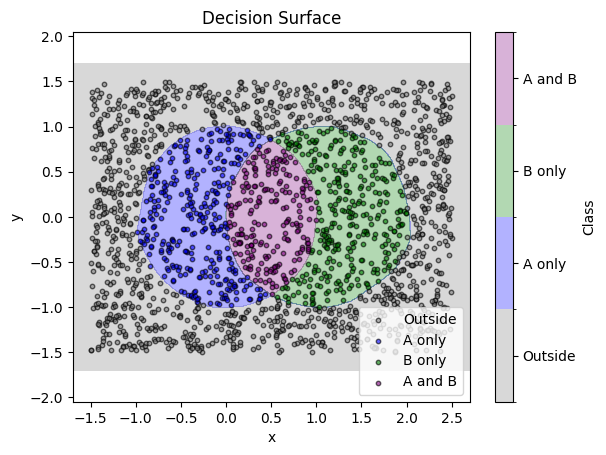

In [105]:
full_net = FullNet()
trained_model, test_acc = train_model(full_net, train_loader, test_loader, n_epochs=20, lr=0.001)

plot_decision_surface(full_net, dataset, venn=False)

Finally, our Full Net achieves just a marginal improvement in accuracy, with peak accuracy at 98.9%. 

## Conclusion

In this notebook, we compared three neural network architectures — a linear model (no hidden layer), a shallow MLP (1 hidden layer), and a deeper model (3 hidden layers) — in classifying points into four regions defined by overlapping circles.

- The **FullNet**, with multiple hidden layers and ReLU activations, consistently achieved the highest accuracy and produced the most precise decision boundaries, especially in capturing the subtle curves of the “A and B” intersection region.
- The **SimpleNet** (a linear model) quickly plateaued and struggled with the non-linear boundaries, particularly failing to distinguish overlapping regions.
- Interestingly, the **shallow MLP** with just **one hidden layer of 8 neurons** performed **remarkably well**, achieving high accuracy and producing decision surfaces that were surprisingly clean. This highlights the expressive power of even a minimal non-linear model when paired with a well-structured classification task and sufficient data.

The training curves showed steady convergence with only minor fluctuations, and the visualizations of decision surfaces clearly illustrated how model complexity impacts boundary flexibility.

This experiment demonstrates that while deeper models offer more precision and generalization capacity, even **small MLPs can be highly effective** for spatial classification when the data is well-structured — a useful insight for situations with limited compute or latency constraints.
